In [ ]:
import os
import pandas as pd
import numpy as np
from astropy import units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties as uncer
import uncertainties.umath as umath

%matplotlib widget

#######################################################################################################
### save flux of each source into individual file
#######################################################################################################
def ClearData():
    data = {
    'freq': [],
    'flux': [],
    'flux_err': []
      }
    return data

Xmatch = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/data/BZCAT_Xmatch_ACC_csv.csv') # # = 37671

#for i in range(0, 1): # 1367 "Use for coding test"
for i, Dataname in enumerate( list(set(Xmatch.name)) ):    # "Use for entire code"
    
    #######################################################################################################
    ### define test source name and set initial setting parameters
    #######################################################################################################
    #Dataname = 'J1256-0547'
    #Dataname = 'J2337-5216'
    #Dataname = 'J0854+2006' # good source
    
    ### declare data format
    df = ClearData()
    
    #######################################################################################################
    ### Read file
    #######################################################################################################
    
    Vdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/VLASS match/' + Dataname + '.csv') 
    
    Gdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/GLEAM match/' + Dataname + '.csv') 
    
    Sdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/SDSS match/' + Dataname + '.csv') 
    
    Wdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/WISE match/' + Dataname + '.csv')
    
    Fdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/FIRST match/' + Dataname + '.csv')
    
    Xdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/XMM-OM match/' + Dataname + '.csv')
    
    Rdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/ROSAT match ver 2/' + Dataname + '.csv')
    
    FGLdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/3FGL match/' + Dataname + '.csv')
    
    Edata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/EGRET match/' + Dataname + '.csv')
    
    SBdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/Swift-BAT match/' + Dataname + '.csv')
    
    XNdata = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/XMM-Newton match/' + Dataname + '.csv')    
    
    FGL_all_data = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/data/BZCAT_Xmatch_ACC_Xmatch_FGL_all.csv')
    
    ### if Dataname have Fermi upper limit constrain, then read in
    if os.path.isfile('/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi upper limit/' + Dataname + '.csv'):
        Fermi_upperlimit_data = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi upper limit/' + Dataname + '.csv')
    
    print('i = ', i, ', V source name = ', Dataname)
    
    #######################################################################################################
    ### extract flux density or magnitude 
    #######################################################################################################
    ## BZCAT
    Name = Vdata.Name[0] #Xmatch data
    RA = Vdata.RA[0]
    DEC = Vdata.DEC[0]
    z = Vdata.z[0]
    cla = Vdata['class'][0]
    flux_ratio = Vdata['flux_ratio'].values[0]        # flux ratio of 1.4/0.843 GHz 
    flux_143 = Vdata['flux_143'].values[0]            # 143 GHz [mJy]
    flux_xray = Vdata['flux_xray'].values[0]          # x-ray flux 0.1-2.4 keV [fW/m^2]; f = 1.0E-15
                                                      # F(lambda) = [W/m^2/(wavelength)]
                                                      # => [fW/m^2] = lambda*F(lambda) = nu*F(nu)
    flux_gamma = Vdata['flux_gamma'].values[0]        # fermi flux 1-100 GeV [ph/cm^2/s]
                                                      # 1 Jy = 1.51E7 ph/s/m^2 = 1.51E3 ph/s/cm^2
    Spec_index = Vdata.Spec_index[0]                  # radio-optical spectral index
    ### ACC
    flux_ALMA = Vdata['flux_ALMA'].values             # flux density [Jy]
    errflux = Vdata['errflux'].values                 # error of flux density [Jy]
    band = Vdata['band'].values  
    freq = Vdata['freq'].values                       # frequency [GHz]
    date = Vdata['date'].values   
    ### VLASS data   
    V_Fint = Vdata['Ftot'].values                    # integrated flux from 2-4 GHz [mJy]
    V_eFint = Vdata['eFtot'].values                       # error of total flux [mJy]
    V_Fp = Vdata['Fpeak'].values                     # peak flux from 2-4 GHz [mJy/beam]
    V_eFp = Vdata['eFpeak'].values                   # error of peak flux [mJy/beam]
    ### GLEAM data
    Fpwide = Gdata['Fpwide'].values                   # peak flux from 170-231 MHz [Jy/beam]
    e_Fpwide = Gdata['e_Fpwide'].values               # error of peak flux from 170-231 MHz [Jy/beam]
    Fintwide = Gdata['Fintwide'].values               # integrated flux from 170-231 MHz [Jy]
    e_Fintwide = Gdata['e_Fintwide'].values           # error of integrated flux from 170-231 MHz [Jy]
    # for all data below number of each value name is the centralfrequency of the measurement
    # frequency ranging from number of each value name +-4 [MHz]
    # eg., Fp076 => Frequecny from 76-4 ~ 76+4 = 72~80 MHz
    # eg., Fp084 => Frequecny from 84-4 ~ 84+4 = 80~88 MHz
    GFp = [None] * 20
    eGFp = [None] * 20
    GFint = [None] * 20
    eGFint = [None] * 20
    GFpname = ['Fp076', 'Fp084', 'Fp092', 'Fp099', 'Fp107', 'Fp115', 'Fp122', 'Fp130', 'Fp143', 'Fp151', 'Fp158', 'Fp166',
                'Fp174', 'Fp181', 'Fp189', 'Fp197', 'Fp204', 'Fp212', 'Fp220', 'Fp227']
    eGFpname = ['e_Fp076', 'e_Fp084', 'e_Fp092', 'e_Fp099', 'e_Fp107', 'e_Fp115', 'e_Fp122', 'e_Fp130', 'e_Fp143', 'e_Fp151', 
                'e_Fp158', 'e_Fp166', 'e_Fp174', 'e_Fp181', 'e_Fp189', 'e_Fp197', 'e_Fp204', 'e_Fp212', 'e_Fp220', 'e_Fp227']
    GFintname = ['Fint076', 'Fint084', 'Fint092', 'Fint099', 'Fint107', 'Fint115', 'Fint122', 'Fint130', 'Fint143', 'Fint151',
                 'Fint158', 'Fint166', 'Fint174', 'Fint181', 'Fint189', 'Fint197', 'Fint204', 'Fint212', 'Fint220', 'Fint227']
    eGFintname = ['e_Fint076', 'e_Fint084', 'e_Fint092', 'e_Fint099', 'e_Fint107', 'e_Fint115', 'e_Fint122', 'e_Fint130',  
                  'e_Fint143', 'e_Fint151', 'e_Fint158', 'e_Fint166', 'e_Fint174', 'e_Fint181', 'e_Fint189', 'e_Fint197', 
                  'e_Fint204', 'e_Fint212', 'e_Fint220', 'e_Fint227']

    for i in range(0, len(GFp)):
        GFp[i] = Gdata[GFpname[i]].values[ np.logical_not(np.isnan(Gdata[GFpname[i]].values)) ]
            # peak flux from 72-80 MHz [Jy/beam]
        eGFp[i] = Gdata[eGFpname[i]].values[ np.logical_not(np.isnan(Gdata[eGFpname[i]].values)) ]
            # rms uncertainty in fit for or peak flux in 072-080MHz [Jy/beam]
        GFint[i] = Gdata[GFintname[i]].values[ np.logical_not(np.isnan(Gdata[GFintname[i]].values)) ]
            # Integrated flux in 072-080MHz [Jy]
        eGFint[i] = Gdata[eGFintname[i]].values[ np.logical_not(np.isnan(Gdata[eGFintname[i]].values)) ]
            # rms uncertainty in fit for integrated flux in 072-80 MHz [Jy/beam] 
            
    ### SDSS data
    Smag = [None]*5
    eSmag = [None]*5
    Smagname = ['umag','gmag','rmag','imag','zmag']
    eSmagname = ['eumag','egmag','ermag','eimag','ezmag']
    for i in range(0, len(Smag)):
        Smag[i] = Sdata[Smagname[i]].values[ np.logical_not(np.isnan(Sdata[Smagname[i]].values)) ]
        eSmag[i] = Sdata[eSmagname[i]].values[ np.logical_not(np.isnan(Sdata[eSmagname[i]].values)) ]
                    
    ### WISE data
    Wmag = [None]*7
    eWmag = [None]*7
    Wmagname = ['W1mag','W2mag','W3mag','W4mag','Jmag','Hmag','Kmag']
    eWmagname = ['eW1mag','eW2mag','eW3mag','eW4mag','eJmag','eHmag','eKmag']
    for i in range(0, len(Wmag)):
        Wmag[i] = Wdata[Wmagname[i]].values
        eWmag[i] = Wdata[eWmagname[i]].values
        
    ### FIRST
    F_Fp = Fdata['Fpeak'].values                  # peak flux between 0.75-1.5 GHz [mJy] (750-1500 MHz)
    F_Fint = Fdata['Fint'].values                # integrated flux between 0.75-1.5 GHz [mJy]
    F_eFp = Fdata['rms_error'].values            # error of flux density [mJy]
    
    ### ROSAT
    Rct = [None]*4
    eRct = [None]*4
    Rcountname = ['CtA','CtB','CtC','CtD']
    eRcountname = ['e_CtA','e_CtB','e_CtC','e_CtD']
    exptime = Rdata['exp_time'].values
    for i in range(0, len(Rct)):
        Rct[i] = Rdata[Rcountname[i]].values     # Count
        eRct[i] = Rdata[eRcountname[i]].values
    
    ### XMM    
    X_SF = [None]*6
    eX_SF = [None]*6
    Xname = ['UVW2','UVM2','UVW1','U','B','V']
    eXname = ['e_UVW2','e_UVM2','e_UVW1','e_U','e_B','e_V']
    for i in range(0, len(X_SF)):
        X_SF[i] = Xdata[Xname[i]].values     # cW/m^2/nm
        eX_SF[i] = Xdata[eXname[i]].values
    
    ### 3FGL
    F35 = FGLdata['F35'].values      # Photon flux summed over 3 bands 1-100 GeV [10^-9^ph/cm^2^/s] = [10^-5 ph/m^2/s]
    e_F35 = FGLdata['e_F35'].values 
    S25 = FGLdata['S25'].values      # Energy flux for 100 MeV-100 GeV [10^-12 erg/s/cm^2]
    e_S25 = FGLdata['e_S25'].values 
    
    ### EGRET
    E_Flux = Edata['Flux'].values     
    E_e_Flux = Edata['e_Flux'].values 
    
    ### SWIFT-BAT
    SB_Flux = SBdata['Flux'].values      
    SB_e_Flux = SBdata['e_Flux'].values 
    
    ### XMM-Newton
    XN_SF = [None]*7
    eXN_SF = [None]*7
    XNname = ['Flux1','Flux2','Flux3','Flux4','Flux5','Flux8','Flux9']
    eXNname = ['e_Flux1','e_Flux2','e_Flux3','e_Flux4','e_Flux5','e_Flux8','e_Flux9']
    for i in range(0, len(XN_SF)):
        XN_SF[i] = XNdata[XNname[i]].values     
        eXN_SF[i] = XNdata[eXNname[i]].values
        
    ### Fermi-LAT all epoch (1, 2, 4)
    name_FGL_all = FGL_all_data.name.values
    FGL_all_Flux1000 = FGL_all_data.Flux1000.values   # Integral photon flux from 1 to 100 GeV
    e_FGL_all_Flux1000 = FGL_all_data.Unc_Flux1000.values
    FGL_all_total_flux = FGL_all_data.Energy_Flux100.values   # Energy flux from 100 MeV to 100 GeV obtained by spectral fitting
    e_FGL_all_total_flux = FGL_all_data.Unc_Energy_Flux100.values
    
    index = np.where(Dataname == name_FGL_all)[0]
    FGL_all_Flux1000 = FGL_all_Flux1000[index]
    e_FGL_all_Flux1000 = e_FGL_all_Flux1000[index]
    FGL_all_total_flux = FGL_all_total_flux[index]
    e_FGL_all_total_flux = e_FGL_all_total_flux[index]
    
    ### Fermi upper limit
    Fermi_upperlimit_freq = Fermi_upperlimit_data.freq.values
    Fermi_upperlimit_flux = Fermi_upperlimit_data.flux.values
    Fermi_upperlimit_eflux = Fermi_upperlimit_data.flux_err.values
    
    #######################################################################################################
    ### Energy unit conversion
    #######################################################################################################
    #########################################
    ###### 1 Jy = 10^-23 erg/s/cm^2/Hz ######
    #########################################
    # set Jy2erg = 1.0E-23 =====> convert Jy to erg/s/cm^2
    # set Jy2erg = 1 =====> display SED flux density in the unit of Jy
    Jy2erg = 1.0E-23
    #######################################################################################################
    ### put peak flux and observed frequency into an array
    #######################################################################################################
    # BZCAT
    BZradio = [143E9, flux_143/1000*143E9*Jy2erg]
    BZxray = [3E17, flux_xray*1.0E-12]
    BZgamma = [1.21E25, flux_gamma*1.21E25/1.51E3/100*Jy2erg]  # 1 -100 GeV => median 50.5 GeV ~1.21*10^25 Hz
    # ACC
    ACCcom = [freq*1E9, flux_ALMA*freq*1E9*Jy2erg]
    # VLASS
    Vpeak = [np.linspace(3E9, 3E9, num = len(V_Fp)), V_Fp*3E9/1000*Jy2erg]  
    #Vpeak[1][np.where( Vpeak[1] < max(Vpeak[1])*0.8 )] = np.nan
    # GLEAM peak flux
    GFpdata = [None] * 20 
    for i in range(0, len(GFp)):
        Gfreq = float(GFpname[i][2::])*1E6 # MHz
        GFpdata[i] = [np.linspace(Gfreq, Gfreq, num = len(GFp[i])), GFp[i]*Gfreq*Jy2erg]
    # SDSS magnitude to AB magnitude to flux density 
    Sdata = [None]*5
    Sabmag = [None]*5
    eSabmag_up = [None]*5
    eSabmag_low = [None]*5
    Sflux = [None]*5
    eSflux_up = [None]*5
    eSflux_low = [None]*5
    b = [1.4E-10, 0.9E-10, 1.2E-10, 1.8E-10, 7.4E-10]
    Sfreq = [8.44E14, 6.40E14, 4.87E14, 4.01E14, 3.36E14]
    ABcorr = [-0.04, 0, 0, 0, 0.02]
    for i in range(0, len(Sdata)):
        for j in range(0, 5):
            if i == j:
                Sabmag[j] = Smag[j]+ABcorr[j] 
                eSabmag_up[j] = Smag[j]+eSmag[j]+ABcorr[j] 
                eSabmag_low[j] = Smag[j]-eSmag[j]+ABcorr[j] 
            
        Sflux[i] = 10**((8.9-Sabmag[i])/2.5) 
        eSflux_up[i] = 10**((8.9-eSabmag_up[i])/2.5)
        eSflux_low[i] = 10**((8.9-eSabmag_low[i])/2.5)
        Sdata[i] = [np.linspace(Sfreq[i], Sfreq[i], num = len(Sflux[i])), Sflux[i]*Sfreq[i]*Jy2erg]   
        
        
    if len(Sdata[0][0]) == 0:
        for i in range(0, 5):
            Sdata[i] = [np.linspace(Sfreq[i], Sfreq[i], num = 2), np.array([np.nan, np.nan])]
    # WISE magnitude to AB magnitude to flux density 
    Wdata = [None]*7
    Wabmag = [None]*7
    eWabmag_up = [None]*7
    eWabmag_low = [None]*7
    Wflux = [None]*7
    eWflux_up = [None]*7
    eWflux_low = [None]*7
    Wfreq = [8.95E13, 6.72E13, 2.59E13, 1.36E13, 2.43E14, 1.78E14, 1.39E14]
    ABcorr = [2.699, 3.339, 5.174, 6.620, 0.91, 1.39, 1.85]
    for i in range(0, len(Wdata)):
        for j in range(0, 7):
            if i == j:
                Wabmag[j] = Wmag[j]+ABcorr[j]
                eWabmag_up[j] = Wmag[j]+eWmag[j]+ABcorr[j]
                eWabmag_low[j] = Wmag[j]-eWmag[j]+ABcorr[j]
            
        Wflux[i] = 10**((8.9-Wabmag[i])/2.5)
        eWflux_up[i] = 10**( (8.9-eWabmag_up[i])/2.5)
        eWflux_low[i] = 10**( (8.9-eWabmag_low[i])/2.5)
        Wdata[i] = [np.linspace(Wfreq[i], Wfreq[i], num = len(Wflux[i])), Wflux[i]*Wfreq[i]*Jy2erg]   
        # Wdata"[0]"[0] => first [0] stands for first band (W1)
        # Wdata[0]"[0]" => second [0] stands for frequency of first band
        # Wdata[0]"[1]" => second [1] stands for flux of first band
        # Wdata[0][0]"[0]" => third [0] stands for frequency of first band of closest source => return specific number
        # Wdata[0][0]"[1]" => third [1] stands for flux of first band of closest source => return specific number        

    # FIRST
    Fpeak = [np.linspace(1.125E9, 1.125E9, num = len(F_Fp)), F_Fp*1.125E9/1000*Jy2erg]
        
    ### ROSAT
    Rdata = [None]*4
    Rflux = [None]*4
    eRflux = [None]*4
    Rfreq = [6.05E16, 3.03E17, 1.69E17, 3.51E17]
    for i in range(0, len(Rdata)):
        Rflux[i] = Rct[i]*1.08E-11/exptime       # convert count to flux [erg/s/cm^2]
        eRflux[i] = eRct[i]*1.08E-11/exptime      # convert count to flux [erg/s/cm^2]
        Rdata[i] = [np.linspace(Rfreq[i], Rfreq[i], num = len(Rflux[i])), Rflux[i]]  
    
    ### XMM-OM
    Xdata = [None]*6
    X_S_flux = [None]*6     # source flux
    eX_S_flux = [None]*6
    Xflux = [None]*6
    eXflux = [None]*6
    Xfreq = [1.41E15, 1.30E15, 1.03E15, 8.72E14, 6.67E14, 5.52E14]
    Xwavelength = [2120, 2310, 2910, 3440, 4500, 5430]  # unit: [Å]
    for i in range(0, len(Xdata)):        
        Xflux[i] = X_SF[i]*Xwavelength[i] #lambda*F(lambda) = nu*F(nu)
        eXflux[i] = eX_SF[i]*Xwavelength[i]
        
        Xdata[i] = [np.linspace(Xfreq[i], Xfreq[i], num = len(Xflux[i])), Xflux[i]]  
    
    ### 3FGL
    #FGL_data = [np.linspace(1.21E25, 1.21E25, num = len(F35)), F35*1.0E-5/1.5E7*1.21E25*Jy2erg] 
    FGL_data = [np.linspace(1.21E25, 1.21E25, num = len(F35)), F35*1.0E-9/1.5E3*1.21E25/100*Jy2erg] 
    FGL_data_fit = [np.linspace(1.21E25, 1.21E25, num = len(S25)), S25*1.0E-12] 
    
    ### EGRET
    E_data = [np.linspace(2.42E24, 2.42E24, num = len(E_Flux)), E_Flux*1.0E-8/1.51E3/100*Jy2erg*2.42E24] ### [erg/s/cm^2]  ##  E_Flux*1.0E-8/1.51E3 [Jy]
    
    ### SWIFT-BAT
    SB_data = [np.linspace(3.39E19, 4.72E19, num = len(SB_Flux)), SB_Flux*1.0E-12]
    
    ### XMM-Newton
    XNdata = [None]*7
    XN_S_flux = [None]*7     
    eXN_S_flux = [None]*7
    XNflux = [None]*7
    eXNflux = [None]*7
    XNfreq = [8.47E16, 1.82E17, 3.63E17, 7.26E17, 2.00E18, 1.51E18, 6.05E17]
    for i in range(0, len(XNdata)):
        XNflux[i] = XN_SF[i]
        eXNflux[i] = eXN_SF[i]
        
        XNdata[i] = [np.linspace(XNfreq[i], XNfreq[i], num = len(XNflux[i])), XNflux[i]]  
       
    ### Fermi-LAT all epoch (1, 2, 4)
    FGL_all_data = [np.linspace(1.21E25, 1.21E25, num = len(FGL_all_Flux1000)), FGL_all_Flux1000*1.0E9*1.0E-5/1.5E7/100*1.21E25*Jy2erg] 
    FGL_all_data_fit = [np.linspace(1.21E25, 1.21E25, num = len(FGL_all_total_flux)), FGL_all_total_flux] 
    
    ### Fermi upper limit
    FGL_upper = [Fermi_upperlimit_freq, Fermi_upperlimit_flux] 
        
    #######################################################################################################
    ### put uncertainty of each data point in to an array
    #######################################################################################################
    # BZCAT peak flux uncertainty
    e_freq_gamma = 0.434*(1.1E25/1.3E25)
    e_freq_xray = 0.434*(2.8E17/3.0E17)
    # ACC peak flux uncertainty
    e_ACC = [0.434*( (errflux*freq*1.0E9*Jy2erg)/(flux_ALMA*freq*1.0E9*Jy2erg) )]
    # VLASS observing frequency and peak flux uncertainty
    e_freq_VLASS = np.array(0.434*(1.0E9/3.0E9)) # frequency error
    e_Vpeak = [0.434*(V_eFp*Jy2erg/(V_Fp*Jy2erg))] # peak flux error
    # GLEAM observing frequency and peak flux uncertainty 
    eGFp_freq = [None]*20 
    eGFpdata = [None]*20
    for i in range(0, len(eGFpdata)):
        eGFp_freq[i] = np.array(0.434*(4/float(GFpname[i][2::]))) # freq error
        eGFpdata[i] = 0.434*(eGFp[i]*Jy2erg/(GFp[i]*Jy2erg)) # peak flux error
    # SDSS observing frequency and peak flux uncertainty 
    eS_freq = [None]*5
    eSdata = [None]*5
    maxfreq = [9.84E14, 7.93E14, 5.54E14, 4.48E14, 3.37E14]
    minfreq = [7.45E14, 5.41E14, 4.29E14, 3.58E14, 2.77E14]
    if ~np.isnan(Sdata[0][1][0]):
        for i in range(0, len(eSdata)):
            low_err = [ 0.434*( (Sfreq[i]-minfreq[i])/Sfreq[i] ) ]
            up_err = [ 0.434*( (maxfreq[i]-Sfreq[i])/Sfreq[i] ) ]
            eS_freq[i] = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T
            eSdata[i] = [0.434*((eSflux_low[i]*Sfreq[i]*Jy2erg-Sdata[i][1])/Sdata[i][1]), 0.434*( (eSflux_up[i]*Sfreq[i]*Jy2erg-Sdata[i][1])/Sdata[i][1]) ]  
    else:
        for i in range(0, len(eSdata)):
            eSdata[i] = [np.array([np.nan, np.nan]), np.array([np.nan, np.nan])]
    # WISE observing frequency and peak flux uncertainty 
    eW_freq = [None]*7
    eWdata = [None]*7
    maxfreq = [1.09E14, 7.57E13, 4.03E13, 1.54E13, 2.75E14, 2.06E14, 1.55E14]
    minfreq = [7.75E13, 5.62E13, 1.74E13, 1.07E13, 2.11E14, 1.50E14, 1.23E14]
    for i in range(0, len(eWdata)):
        low_err = [ 0.434*( (Wfreq[i]-minfreq[i])/Wfreq[i] ) ]
        up_err = [ 0.434*( (maxfreq[i]-Wfreq[i])/Wfreq[i] ) ]
        eW_freq[i] = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T        
        eWdata[i] = [ 0.434*( (eWflux_low[i]*Wfreq[i]*Jy2erg-Wdata[i][1])/Wdata[i][1] ), 0.434*( (eWflux_up[i]*Wfreq[i]*Jy2erg-Wdata[i][1])/Wdata[i][1] ) ]   
        
    # FIRST observing frequency and peak flux uncertainty
    e_freq_FIRST = np.array(0.434*(0.375E9/1.125E9)) # frequency error
    e_Fpeak = [0.434*(F_eFp*Jy2erg/(F_Fp*Jy2erg))] # peak flux error
    
    ### ROSAT
    eR_freq = [None]*4
    eRdata = [None]*4
    maxfreq = [9.69E16, 4.84E17, 2.18E17, 4.48E17]
    minfreq = [2.42E16, 1.21E17, 1.21E17, 2.18E17]
    for i in range(0, len(eRdata)):
        low_err = [ 0.434*( (Rfreq[i]-minfreq[i])/Rfreq[i] ) ]
        up_err = [ 0.434*( (maxfreq[i]-Rfreq[i])/Rfreq[i] ) ]
        eR_freq[i] = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T        
        eRdata[i] = 0.434*( eRflux[i]/Rflux[i] ) 
    
    ### XMM-OM
    eX_freq = [None]*6
    eXdata = [None]*6
    maxfreq = [1.67E15, 1.50E15, 1.23E15, 9.90E14, 7.87E14, 5.98E14]
    minfreq = [1.17E15, 1.11E15, 8.31E14, 7.71E14, 6.12E14, 5.11E14]
    for i in range(0, len(eXdata)):
        low_err = [ 0.434*( (Xfreq[i]-minfreq[i])/Xfreq[i] ) ]
        up_err = [ 0.434*( (maxfreq[i]-Xfreq[i])/Xfreq[i] ) ]
        eX_freq[i] = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T   
        eXdata[i] = [ 0.434*( eXflux[i]/Xflux[i] )]  
    
    ### 3FGL
    eFGL_freq = 0.434*(1.21E25/2.42E25)
    e_FGL_flux = 0.434*( (e_F35*1.0E-5/1.5E7*1.21E25*Jy2erg)/(F35*1.0E-5/1.5E7*1.21E25*Jy2erg))
    e_FGL_flux_fit = 0.434*( e_S25*1.0E-12/(S25*1.0E-12) ) 
    
    ### EGRET
    e_E_flux = 0.434*( (E_e_Flux*1.0E-8/1.51E3*Jy2erg*2.42E22)/E_data[1] )
        
    ### Swift-XRT
    eSB_freq = 0.434*(2.19E19/4.72E19)
    e_SB_flux = 0.434*( (SB_e_Flux*1.0E-12)/SB_data[1] )
        
    ### XMM-Newton
    eXN_freq = [None]*7
    eXNdata = [None]*7
    maxfreq = [1.21E17, 2.42E17, 4.84E17, 9.69E17, 2.91E18, 2.91E18, 1.09E18]
    minfreq = [4.84E16, 1.21E17, 2.42E17, 4.84E17, 1.09E18, 1.21E17, 1.21E17]
    for i in range(0, len(eXNdata)):
        low_err = [ 0.434*( (XNfreq[i]-minfreq[i])/XNfreq[i] ) ]
        up_err = [ 0.434*( (maxfreq[i]-XNfreq[i])/XNfreq[i] ) ]
        eXN_freq[i] = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T        
        eXNdata[i] = [ 0.434*( eXNflux[i]/XNflux[i] ), 0.434*( eXNflux[i]/XNflux[i]) ]   
        
    ### Fermi-LAT all epoch (1, 2, 4)
    eFGL_freq = 0.434*(1.21E25/2.42E25)
    e_FGL_all_flux = 0.434*( (e_FGL_all_Flux1000*1.0E9*1.0E-5/1.5E7*1.21E25*Jy2erg)/(FGL_all_Flux1000*1.0E9*1.0E-5/1.5E7*1.21E25*Jy2erg))
    e_FGL_all_flux_fit = 0.434*( e_FGL_all_total_flux/(FGL_all_total_flux) )
    
    ### Fermi upper limit
    freq_bin = ( (np.log10(Fermi_upperlimit_freq[2]) - np.log10(Fermi_upperlimit_freq[1])) )/2
    e_FGL_upper_freq = 0.434*(freq_bin/np.log10(Fermi_upperlimit_freq))
    e_FGL_upper_flux = 0.434*(Fermi_upperlimit_eflux/Fermi_upperlimit_flux)
        
    #######################################################################################################
    ### data arrange
    #######################################################################################################
    ### GLEAM
    nGFpdata = [item for sublist in GFpdata for item in sublist]
    nGFpfreq = []
    nGFpflux = []
    for i in range(0, int(len(GFpdata))):
        nGFpfreq.append(nGFpdata[2*i])
        nGFpflux.append(nGFpdata[2*i+1])
        
    nGFpfreq = np.array([item for sublist in nGFpfreq for item in sublist])
    nGFpflux = np.array([item for sublist in nGFpflux for item in sublist])
    
    ### FIRST error propagation
    err = [0]*len( np.array(e_Fpeak).flatten() )
        
    for j in range(0, len( np.array(e_Fpeak).flatten() )):
        err[j] = uncer.ufloat(np.array(Fpeak).flatten()[j], np.array(e_Fpeak).flatten()[j] ) 
        
    if len(np.isnan( np.array(e_Fpeak).flatten() )) == len(np.array(e_Fpeak).flatten()):
        F_errpropa = uncer.ufloat(np.nan, np.nan)
    else:
        F_errpropa = np.nansum(err)/len(np.array(e_Fpeak).flatten()[~np.isnan( np.array(e_Fpeak).flatten() )])
    
    ### VLASS error propagation
    err = [0]*len( np.array(e_Vpeak).flatten() )
        
    if len(np.isnan( np.array(e_Vpeak).flatten() )) == len(np.array(e_Vpeak).flatten()):
        V_errpropa = uncer.ufloat(np.nan, np.nan)
    else:
        for j in range(0, len( np.array(e_Vpeak).flatten() )):
            err[j] = uncer.ufloat(np.array(Vpeak).flatten()[j], np.array(e_Vpeak).flatten()[j] ) 
        V_errpropa = np.nansum(err)/len(np.array(e_Vpeak).flatten()[~np.isnan( np.array(e_Vpeak).flatten() )])
        
    ### WISE
    nWfreq = []
    nWflux = []
    nWflux_err = []
    for i in range(0, int(len(Wdata))):
        nWfreq.append(Wdata[i][0][0])
        nWflux.append(Wdata[i][1][0])
        nWflux_err.append(eWdata[i][0][0])
        
    ### SDSS
    nSfreq = []
    nSflux = []
    nSflux_err = []
    for i in range(0, len(Sdata)):
        nSfreq.append(Sdata[i][0][0])
        nSflux.append(Sdata[i][1][0])
        nSflux_err.append(eSdata[i][0][0])
    
    ### ACC
    ne_ACC = [item for sublist in e_ACC for item in sublist]
        
    ### XMM
    nXfreq = []
    nXflux = []
    nXflux_err = []
    for i in range(0, int(len(Xdata))):
        nXfreq.append(Xdata[i][0][0])
        nXflux.append(Xdata[i][1][0])
        nXflux_err.append(eXdata[i][0][0])
        
    ### XMM-Newton
    nXNfreq = []
    nXNflux = []
    nXNflux_err = []
    for i in range(0, len(XNdata)):
        nXNfreq.append(XNdata[i][0][0])
        nXNflux.append(XNdata[i][1][0])
        nXNflux_err.append(eXNdata[i][0][0])
        
    ### ROSAT
    nRfreq = []
    nRflux = []
    nRflux_err = []
    for i in range(0, len(Rct)):
        nRfreq.append(Rdata[i][0][0])
        nRflux.append(Rdata[i][1][0])
        nRflux_err.append(eRdata[i][0])
       
    ### EGRET
    nEfreq = []
    nEflux = []
    nEflux_err = []
    for i in range(0, len( E_data[1][~np.isnan(E_data[1])] ) ):
        nEfreq.append(E_data[0][i])
        nEflux.append(E_data[1][i])
        nEflux_err.append(e_E_flux[i])
        
    #######################################################################################################
    ### put all data into array
    #######################################################################################################       
    
    if np.isnan(Vpeak[1][0]):
        # flux frequency combination
        allfreq = [ ]
        allfreq = np.hstack([nGFpfreq.flatten(), Fpeak[0][0].flatten(), Vpeak[0][0], ACCcom[0][0::].flatten(),  
                         BZradio[0], np.array(nWfreq).flatten(), np.array(nSfreq).flatten(), np.array(nXfreq).flatten(),
                         BZxray[0], SB_data[0][~np.isnan(SB_data[1])], np.array(nXNfreq).flatten(), np.array(nRfreq).flatten(), BZgamma[0], 
                         np.array(nEfreq).flatten(), FGL_data[0][0], FGL_data_fit[0][0], FGL_all_data[0], FGL_all_data_fit[0], FGL_upper[0]])
        # flux combination
        allflux = [ ]
        allflux = np.hstack([nGFpflux.flatten(), np.nansum(Fpeak[1][0::]).flatten(), Vpeak[1][0], ACCcom[1][0::], 
                         BZradio[1], np.array(nWflux).flatten(), np.array(nSflux).flatten(), np.array(nXflux).flatten(),
                         BZxray[1], SB_data[1][~np.isnan(SB_data[1])], np.array(nXNflux).flatten(), np.array(nRflux).flatten(), BZgamma[1], 
                         np.array(nEflux).flatten(), FGL_data[1][0], FGL_data_fit[1][0], FGL_all_data[1], FGL_all_data_fit[1], FGL_upper[1]])
    else:
        # flux frequency combination
        allfreq = [ ]
        allfreq = np.hstack([nGFpfreq.flatten(), Fpeak[0][0].flatten(), Vpeak[0][0].flatten(), ACCcom[0][0::].flatten(),  
                         BZradio[0], np.array(nWfreq).flatten(), np.array(nSfreq).flatten(), np.array(nXfreq).flatten(),
                         BZxray[0], SB_data[0][~np.isnan(SB_data[1])], np.array(nXNfreq).flatten(), np.array(nRfreq).flatten(), BZgamma[0], 
                         np.array(nEfreq).flatten(), FGL_data[0][0], FGL_data_fit[0][0], FGL_all_data[0], FGL_all_data_fit[0], FGL_upper[0]])
        # flux combination
        allflux = [ ]
        allflux = np.hstack([nGFpflux.flatten(), np.nansum(Fpeak[1][0::]).flatten(), np.nansum(Vpeak[1][0::]).flatten(), ACCcom[1][0::], 
                         BZradio[1], np.array(nWflux).flatten(), np.array(nSflux).flatten(), np.array(nXflux).flatten(),
                         BZxray[1], SB_data[1][~np.isnan(SB_data[1])], np.array(nXNflux).flatten(), np.array(nRflux).flatten(), BZgamma[1], 
                         np.array(nEflux).flatten(), FGL_data[1][0], FGL_data_fit[1][0], FGL_all_data[1], FGL_all_data_fit[1], FGL_upper[1]])
   
    # flux error combination
    allflux_err = [ ]
    allflux_err = np.hstack([ np.array(eGFpdata).flatten(), float(F_errpropa.s), float(V_errpropa.s), np.array(ne_ACC).flatten(), np.nan, 
                             np.array(nWflux_err).flatten(), np.array(nSflux_err).flatten(), np.array(nXflux_err).flatten(), np.nan, e_SB_flux[~np.isnan(SB_data[1])], 
                             np.array(nXNflux_err).flatten(),
                            np.array(nRflux_err).flatten(), np.nan, np.array(nEflux_err).flatten(), e_FGL_flux[0], e_FGL_flux_fit[0], e_FGL_all_flux, 
                             e_FGL_all_flux_fit, e_FGL_upper_flux   ]) 

    #######################################################################################################
    ### save parameters into a csv file
    #######################################################################################################
        
    ## save file
    for i in range(0, len(allfreq)):
        df['freq'].append(allfreq[i])
        df['flux'].append(allflux[i])
        df['flux_err'].append(allflux_err[i])
    
    CSVfile = f'/Users/87steven/Documents/ASIAA/Blazar SED code and data/source individual flux 2023_2_15/{Dataname}_flux.csv'   
    dff = pd.DataFrame(df)      
    dff.to_csv(CSVfile, index = False)
    
    print('================================================ CSV File saved succfully ================================================')


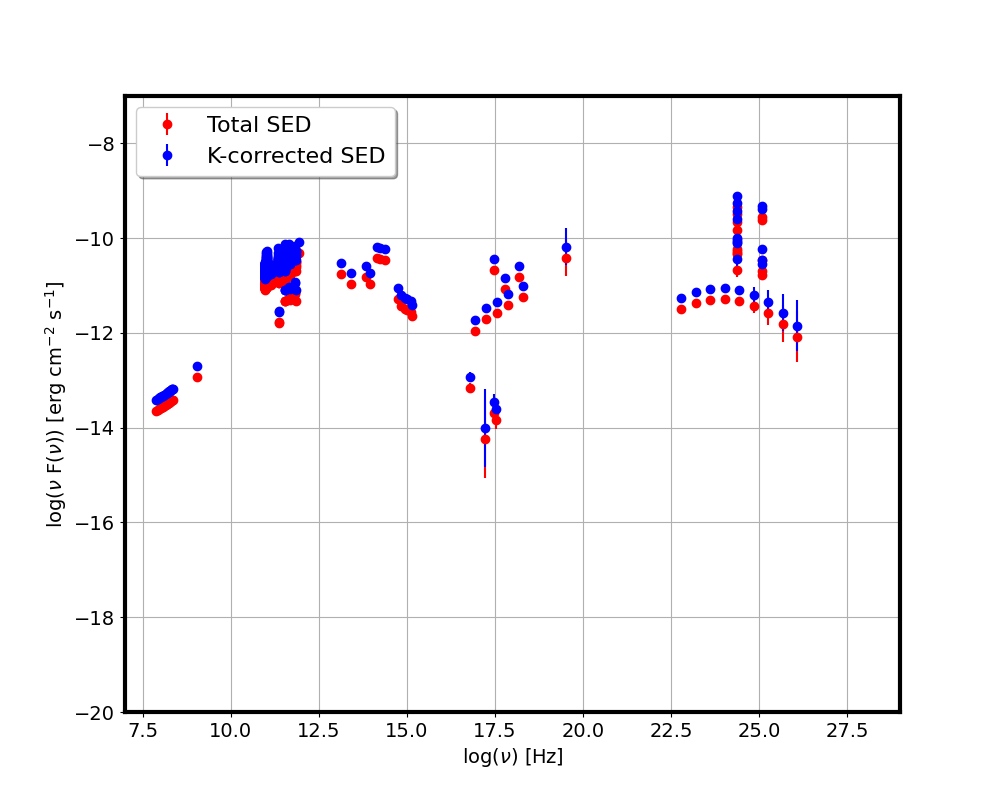

In [21]:
test = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/source individual flux 11_15/'+Dataname+'_flux.csv') 

freq = test.freq.values
flux = test.flux.values
flux_err = test.flux_err.values

z = 0.306
flux_Kcorrected = flux*(1+z)**2

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

#ax.plot(np.log10(freq), np.log10(flux), '.', color = 'red', label = 'Total SED')
ax.errorbar(np.log10(freq), np.log10(flux), yerr = flux_err, marker = "o", color = "red", ecolor = "red", linestyle = '', label = 'Total SED') 
ax.errorbar(np.log10(freq), np.log10(flux_Kcorrected), yerr = flux_err, marker = "o", color = "blue", ecolor = "blue", linestyle = '', label = 'K-corrected SED') 

ax.set_xlim(7, 29)
ax.set_ylim(-20, -7) 

plt.legend(loc = 'upper left', shadow = True, fontsize = 16, markerscale = 1) 

#ax.set_xscale('log')
#ax.set_yscale('log')
plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('log($\\nu$ F($\\nu$)) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)


#figurename = 'J1256-0547 SED Test'
#plt.title(figurename, fontsize = 16)